# Procesamiento del Lenguaje Natural Análisis de redes sociales en torno a #SOSMarMenor

Como sabemos, cualquier proyecto de Machine Learning implica resolver un problema que podemos
formular como pregunta, y las aproximaciones desde el PLN no lo son menos. Dado el caso en cuestión, la
pregunta a la que deberíamos dar respuesta podría ser: ¿qué podemos aprender de lo que ha sucedido en
torno a la crisis del Mar Menor estos últimos años partiendo de la actividad existente en la redes
sociales?


## Exploración de datos

En primer lugar, resulta recomendable realizar una revisión superficial de los datos como primera
aproximación a su comprensión. Aplica las técnicas que te permita obtener algo de información
sobre el dataset.


In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from IPython.display import HTML
import requests
import json
from requests.exceptions import HTTPError

from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim
from nltk import word_tokenize
from nltk.tokenize import ToktokTokenizer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [78]:
df = pd.read_csv("dataset_mar_menor_tweets.csv")
pd.set_option('display.max_colwidth', None)

df.head(8)

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count
0,2022-04-27 07:03:40+00:00,1519210655705972737,Agricultura y construcciones masivas y ningún respeto han sido dos de las causas de que el Mar Menor esté muriendo o ya esté muerto. Ya no hay óxigeno en el agua \n#SOSMarMenor https://t.co/666fOPlV37,Guzmani96580514,1,2,2
1,2022-04-27 06:47:37+00:00,1519206616431796224,El Instituto Oceanográfico alerta del riesgo de una nueva anoxia en el Mar Menor por las lluvias y los nutrientes https://t.co/IjBwPwKhOH a través de @eldiariomurcia #SOSMarMenor,annamaryen,0,0,0
2,2022-04-27 06:45:23+00:00,1519206054457917440,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,EcoantifaK,0,0,0
3,2022-04-27 05:57:18+00:00,1519193955166007297,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental https://t.co/60p3ZwnXk9,Strikebis,0,0,0
4,2022-04-27 05:57:15+00:00,1519193940985012224,#SOSMarMenor \n@IEOoceanografia alerta del riesgo de un nuevo episodio de anoxia en el #MarMenor #Murcia por el estado de eutrofización de #LaLaguna (@mitecogob)\nA que esperáis a tomar medidas\n@regiondemurcia \n@desdelamoncloa \n@SaludPublicaEs \n@sosmarmenorofi https://t.co/W9zK3KsBCy,RafaSEF1,0,1,0
5,2022-04-27 05:54:38+00:00,1519193282638716930,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental https://t.co/B81xxVNRr9,Strikebis,0,1,0
6,2022-04-27 05:52:10+00:00,1519192662397665280,"#AlertaMedioAmbental\n“25 años de negligencia institucional no sólo han ocasionado un impacto imperdonable en un entorno natural único, sino que está afectando a la viabilidad del trabajo autónomo y las pymes de la zona”\n📰⬇️ #SOSMarMenor\nhttps://t.co/egGST0WOe0",EcoantifaK,1,16,20
7,2022-04-27 05:31:30+00:00,1519187462593163264,Buenos días.\n#SOSRealMurcia #ComoUnaSolaAlma #ElQueLaHayaHechoQueLaPague #JusticiaParaElMurcia #TebasDimisión\n\n#SOSMarMenor,jorgefenor,0,0,0


In [79]:
df.shape

(65578, 7)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65578 entries, 0 to 65577
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Datetime       65578 non-null  object
 1   Tweet_Id       65578 non-null  int64 
 2   Text           65578 non-null  object
 3   Username       65578 non-null  object
 4   Reply_Count    65578 non-null  int64 
 5   Like_Count     65578 non-null  int64 
 6   Retweet_Count  65578 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


Podemos ver que no tenemos ningún null en nuestro dataset lo cual nos facilitará el trabajo

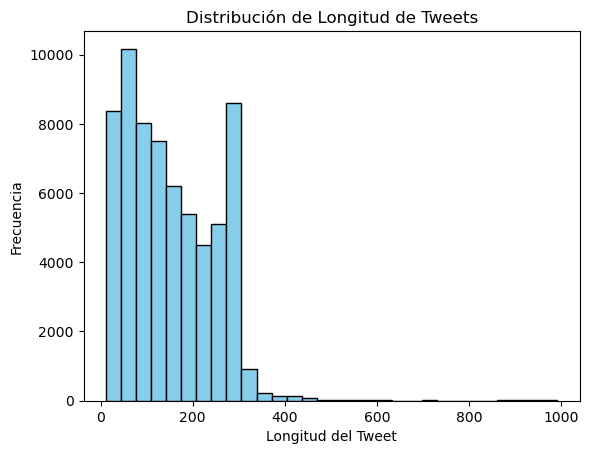

In [81]:
lengths = df['Text'].apply(len)
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Longitud de Tweets')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')
plt.show()

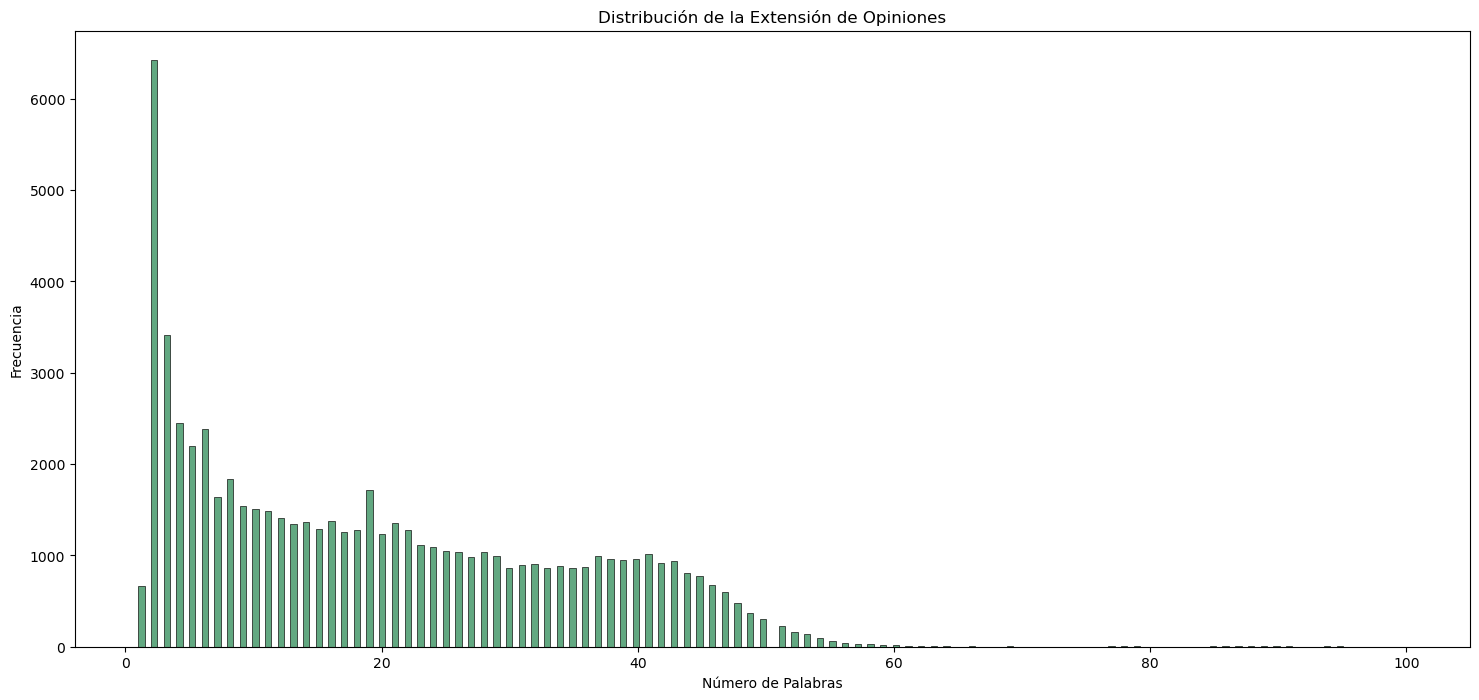

In [82]:
df['length'] = df['Text'].apply(lambda x : len(x.split()))

plt.figure(figsize=(18, 8))
sns.histplot(df['length'], bins=200, color="#2E8B57")
plt.title('Distribución de la Extensión de Opiniones')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

In [83]:
media_palabras = df['length'].mean()
print("Media:",media_palabras)

opiniones_cercanas_media = df[(df['length'] >= media_palabras - 1) & (df['length'] <= media_palabras + 1)]['Text']

print("Tweets cercanas a la media de palabras:")
for i, opinion in enumerate(opiniones_cercanas_media[:5]):
    print(f"{i + 1}. {opinion}")


Media: 19.57205160267163
Tweets cercanas a la media de palabras:
1. #SOSMarMenor 
#Cartaginense51 
@FeijooGalicia @frankorozco1963 @rafarodrict89 @roderotomas 
Lo que está haciendo el Partido Popular con el Mar Menor es imperdonable https://t.co/vI7EAHDuLG
2. #SOSMarMenor 
#Cartaginense51 
@itremurcia @costacruceros @CruceroAdicto @AE_TurUSC @Armada_esp @GuiaRepsol 
El Partido Popular lleva al mar menor al colapso absoluto https://t.co/thlUCRbaRp
3. @marta_campi1 @EcoenAccionRM @CapitanaAlMando @BioMundo3 Lo que está haciendo el Partido Popular con el Mar Menor es injustificable.
#SOSMarMenor 
#Cartaginense51
4. @MaestroJediJepi @MarmenorKO_ @NoeliaArroyoHer @UnionEuropeaRD @regiondemurcia @PPRMurcia Lo que está haciendo el Partido Popular en Cartagena es intolerable.
#SOSMarMenor 
#Cartaginense51
5. #SOSMarMenor 
#Cartaginense51 
@AytoCartagenaES @huelva_info @josecmart2504 @chema32 @esther52269078 @AVVPOZOESTRECHO 
El Mar Menor es la mayor desvergüenza del Partido Popular https://t.c

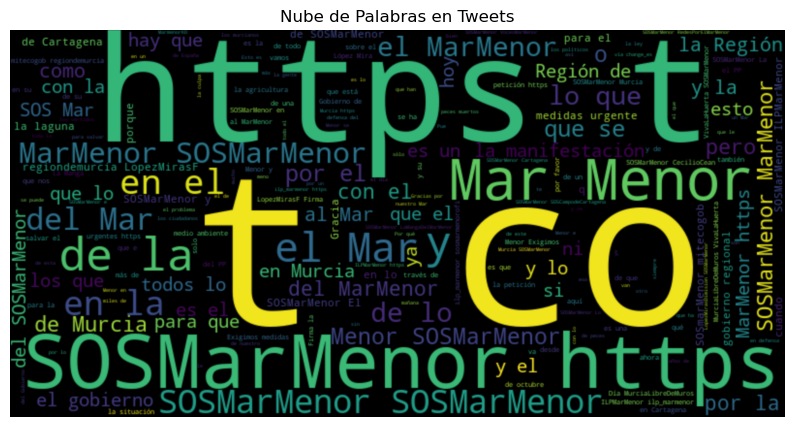

In [84]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['Text']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.title('Nube de Palabras en Tweets')
plt.show()

In [85]:
hashtags = df['Text'].apply(lambda x: [word.lower() for word in x.split() if word.startswith('#')])
hashtags = [item for sublist in hashtags for item in sublist]  # Convertir lista de listas a una lista plana

top_hashtags = pd.Series(hashtags).value_counts().head(10)

# Obtener la frecuencia de menciones
mentions = df['Text'].apply(lambda x: [word.lower() for word in x.split() if word.startswith('@')])
mentions = [item for sublist in mentions for item in sublist]  # Convertir lista de listas a una lista plana

# Mostrar las 10 menciones más frecuentes
top_mentions = pd.Series(mentions).value_counts().head(10)

# Identificar las palabras más frecuentes en el conjunto de datos
all_words = df['Text'].str.split(expand=True).unstack().value_counts()
top_words = all_words.head(10)


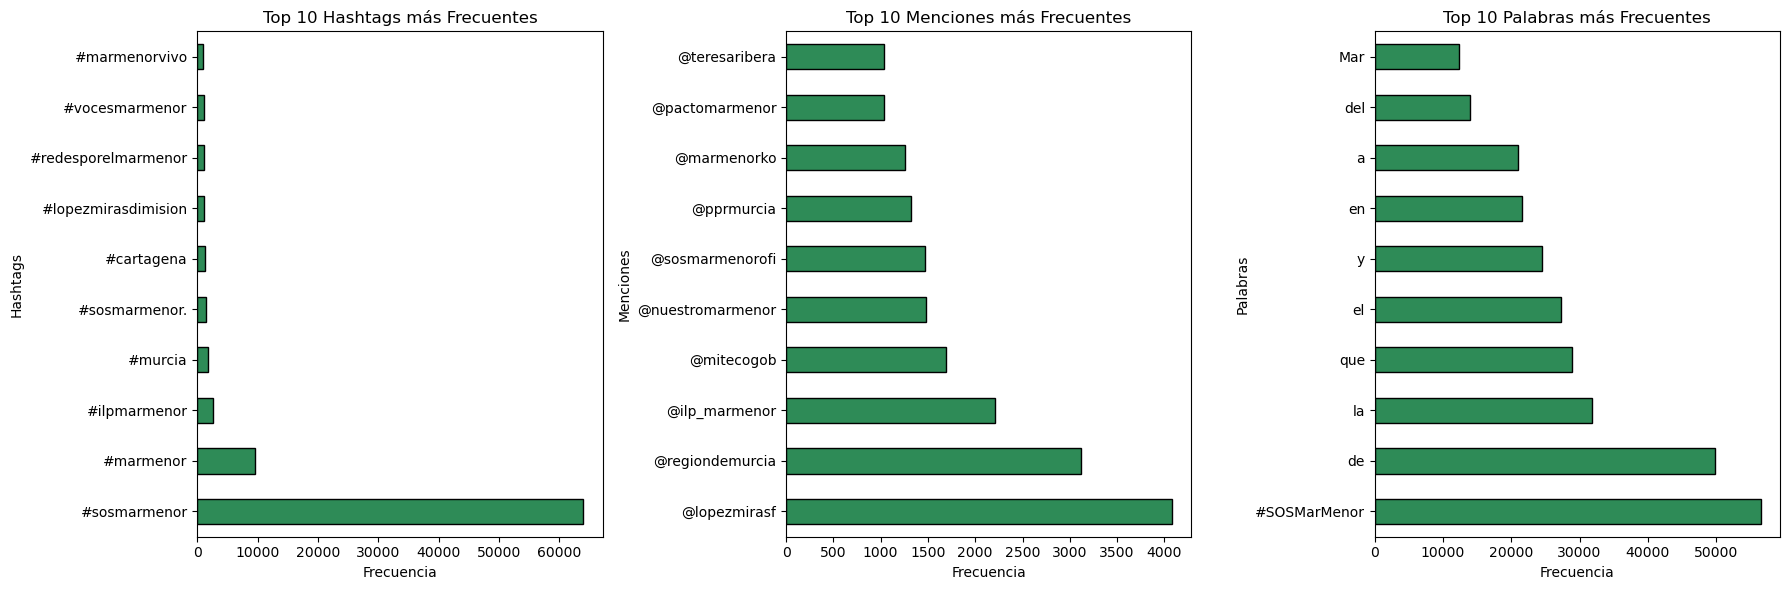

In [86]:
# Crear subgráficos para las visualizaciones
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Visualización de los 10 hashtags más frecuentes
top_hashtags.plot(kind='barh', color='#2E8B57', edgecolor='black', ax=axes[0])
axes[0].set_title('Top 10 Hashtags más Frecuentes')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Hashtags')

# Visualización de las 10 menciones más frecuentes
top_mentions.plot(kind='barh', color='#2E8B57', edgecolor='black', ax=axes[1])
axes[1].set_title('Top 10 Menciones más Frecuentes')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Menciones')

# Visualización de las 10 palabras más frecuentes
top_words.plot(kind='barh', color='#2E8B57', edgecolor='black', ax=axes[2])
axes[2].set_title('Top 10 Palabras más Frecuentes')
axes[2].set_xlabel('Frecuencia')
axes[2].set_ylabel('Palabras')

# Ajustar el diseño de los subgráficos
plt.tight_layout()
plt.show()


In [87]:
df.columns


Index(['Datetime', 'Tweet_Id', 'Text', 'Username', 'Reply_Count', 'Like_Count',
       'Retweet_Count', 'length'],
      dtype='object')

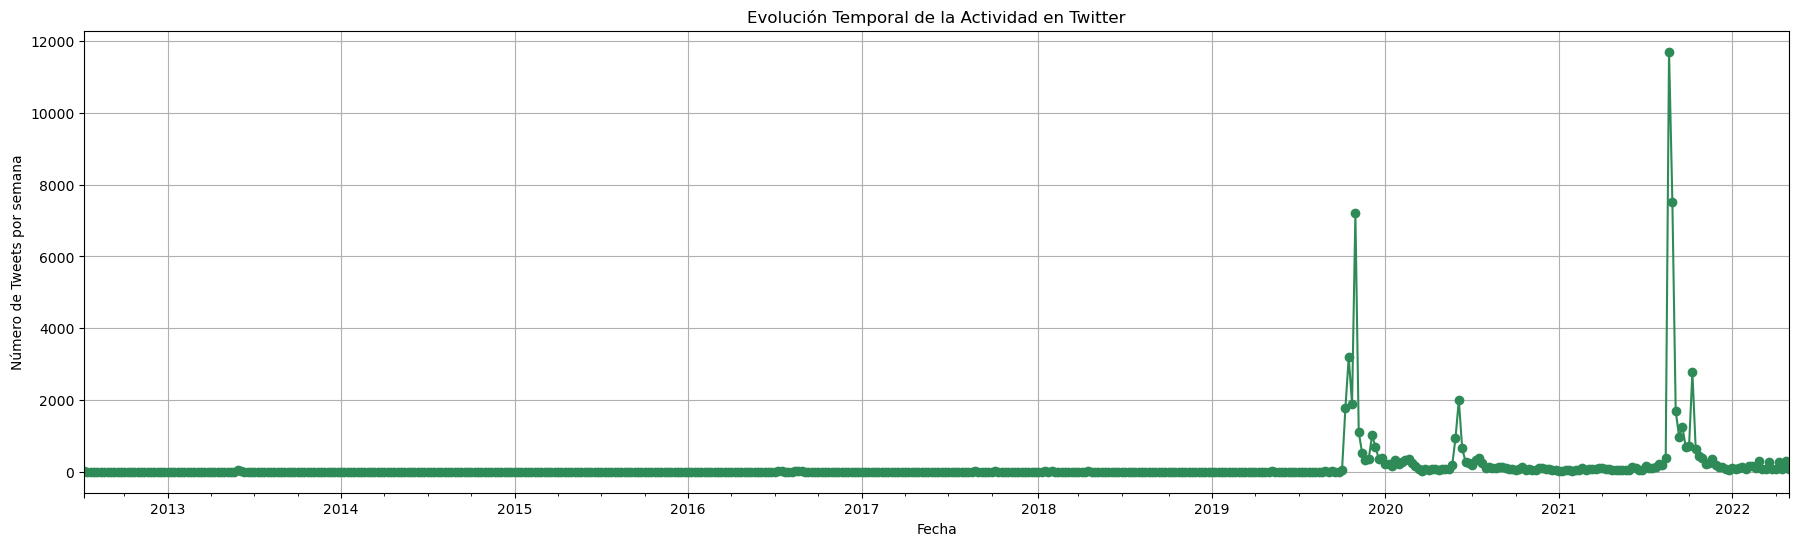

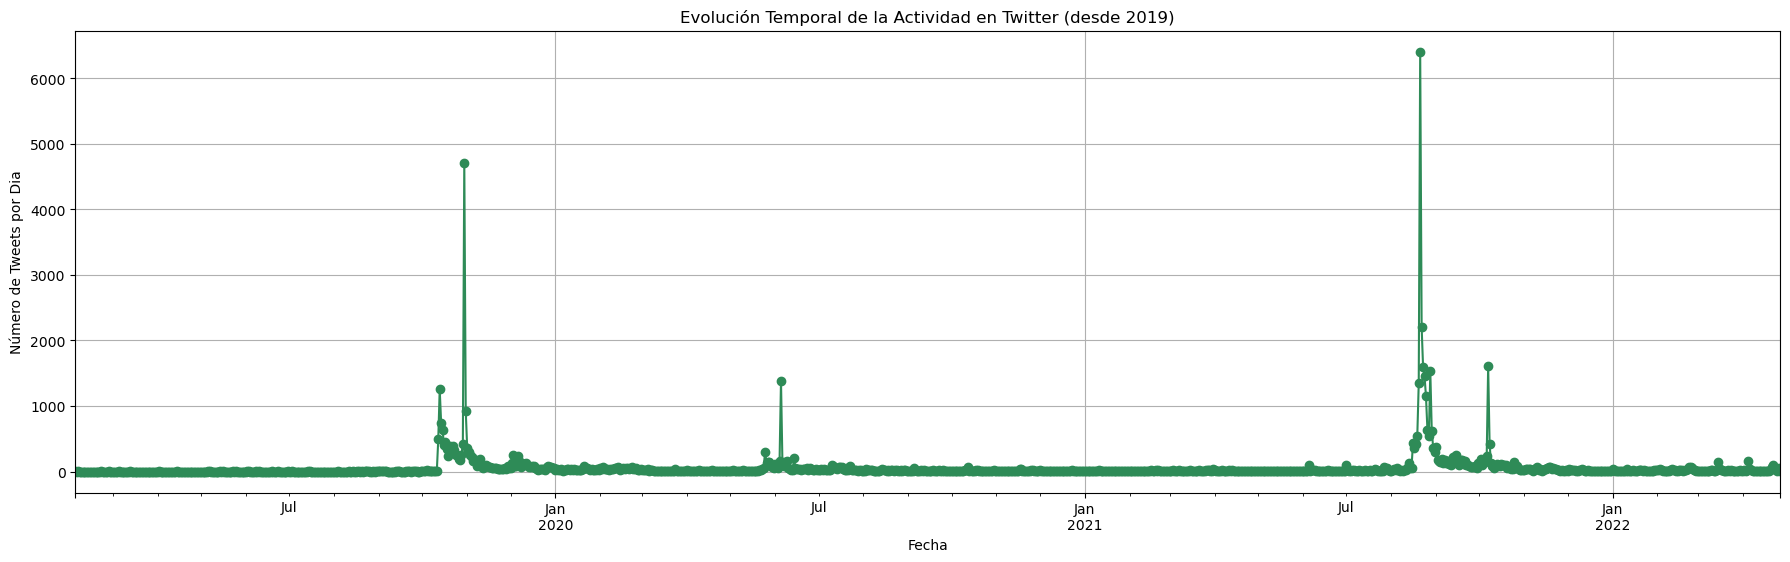

In [88]:
df_copy = df.copy()

if 'Datetime' in df_copy.columns and pd.api.types.is_datetime64_any_dtype(df_copy['Datetime']):
    print("La columna 'Datetime' ya está en formato datetime.")
else:
    if 'Datetime' in df_copy.columns:
        df_copy['Datetime'] = pd.to_datetime(df_copy['Datetime'])

if not isinstance(df_copy.index, pd.DatetimeIndex):
    df_copy.set_index('Datetime', inplace=True)

tweets_por_semana = df_copy.resample('W').size()

plt.figure(figsize=(22, 6))
tweets_por_semana.plot(color='#2E8B57', marker='o')
plt.title('Evolución Temporal de la Actividad en Twitter')
plt.xlabel('Fecha')
plt.ylabel('Número de Tweets por semana')
plt.grid(True)
plt.show()

df_desde_2019 = df_copy[df_copy.index >= '2019-01-01']

tweets_por_dia = df_desde_2019.resample('D').size()

plt.figure(figsize=(22, 6))
tweets_por_dia.plot(color='#2E8B57', marker='o')
plt.title('Evolución Temporal de la Actividad en Twitter (desde 2019)')
plt.xlabel('Fecha')
plt.ylabel('Número de Tweets por Dia')
plt.grid(True)
plt.show()


Podemos ver que en 2013 había actividad junto a otros años, pero realmente donde mas actividad comienza a haber es a finales de 2019. Asi que haremos un focus especifico sobre esa zona mostrando por tweets por dia

##  Preprocesamiento de texto

Como sabemos, preprocesar un texto supone realizar diferentes tareas que lo dejen preparado
para tareas posteriores. En este caso, como quizá puede ser útil no eliminar tokens referidos a
otros hashtags o nombres de usuario (que pueden ser colectivos u organizaciones ciudadanas) que
aparezcan en los mismos como parte de su contenido, ya es contenido que nos interesa preservar,
puede ser aconsejable guardar los tuits preprocesados de 2 formas: una en cuyo limpiado se
incluyan hashtags y nombres de usuarios, y otra en la que se preserven como parte del tuit
preprocesado.


In [89]:
df.columns

Index(['Datetime', 'Tweet_Id', 'Text', 'Username', 'Reply_Count', 'Like_Count',
       'Retweet_Count', 'length'],
      dtype='object')

In [90]:
df

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count,length
0,2022-04-27 07:03:40+00:00,1519210655705972737,Agricultura y construcciones masivas y ningún respeto han sido dos de las causas de que el Mar Menor esté muriendo o ya esté muerto. Ya no hay óxigeno en el agua \n#SOSMarMenor https://t.co/666fOPlV37,Guzmani96580514,1,2,2,33
1,2022-04-27 06:47:37+00:00,1519206616431796224,El Instituto Oceanográfico alerta del riesgo de una nueva anoxia en el Mar Menor por las lluvias y los nutrientes https://t.co/IjBwPwKhOH a través de @eldiariomurcia #SOSMarMenor,annamaryen,0,0,0,26
2,2022-04-27 06:45:23+00:00,1519206054457917440,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,EcoantifaK,0,0,0,3
3,2022-04-27 05:57:18+00:00,1519193955166007297,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental https://t.co/60p3ZwnXk9,Strikebis,0,0,0,4
4,2022-04-27 05:57:15+00:00,1519193940985012224,#SOSMarMenor \n@IEOoceanografia alerta del riesgo de un nuevo episodio de anoxia en el #MarMenor #Murcia por el estado de eutrofización de #LaLaguna (@mitecogob)\nA que esperáis a tomar medidas\n@regiondemurcia \n@desdelamoncloa \n@SaludPublicaEs \n@sosmarmenorofi https://t.co/W9zK3KsBCy,RafaSEF1,0,1,0,34
...,...,...,...,...,...,...,...,...
65573,2012-07-15 07:35:33+00:00,224406836554629120,Seguid destruyendo el Mar Menor y luego quejaros porque hay poco turismo y el que hay no vuelve xq se lo comen las medusas... #SOSmarmenor,zanguanga,0,3,13,25
65574,2012-07-11 12:26:33+00:00,223030514863448064,ANSE advierte a Valcárcel de que 'pagará el daño hecho al Mar Menor' http://t.co/8DUrxTh6 vía @diariolaopinion #SOSMarMenor,zanguanga,0,0,0,17
65575,2012-07-10 18:41:13+00:00,222762417812291585,"El Mar Menor podría ser un destino de primer nivel, si no fuera por estos políticos depredadores #turismo #MurciaQueHermosaEras #SOSMarMenor",zanguanga,0,1,1,20
65576,2012-07-10 18:39:21+00:00,222761947647578113,Murcia podría haber sido un paraíso turístico y van a terminar de arruinarlo #turismo #MurciaQueHermosaEras #SOSMarMenor #MeDueleMurcia,zanguanga,0,1,4,17


In [113]:
def preprocess_text_with_hashtag_and_usernames(text):
    text = ''.join(
        [char for char in text if char not in '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'])
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    text = ' '.join(tokens).replace('# ', '#').replace('@ ', '@')
    text = re.sub(r'http\S+', '', text).strip()
    return text


def preprocess_text(text):
    text = re.sub(r'#[A-Za-z0-9_]+|@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'http\S+', '', text).strip()
    return text

df['Text_cleaned_hashtag_and_username'] = df['Text'].apply(preprocess_text_with_hashtag_and_usernames)
df['Text_cleaned'] = df['Text'].apply(preprocess_text)

In [114]:
df['Text_cleaned'].iloc[4]

'alerta riesgo nuevo episodio anoxia eutrofización esperáis tomar medidas'

In [115]:
df['Text_cleaned_hashtag_and_username'].iloc[4]

'SOSMarMenor IEOoceanografia alerta riesgo nuevo episodio anoxia MarMenor Murcia eutrofización LaLaguna mitecogob esperáis tomar medidas regiondemurcia desdelamoncloa SaludPublicaEs sosmarmenorofi'

In [116]:
df['Text'].iloc[4]

'#SOSMarMenor \n@IEOoceanografia alerta del riesgo de un nuevo episodio de anoxia en el #MarMenor #Murcia por el estado de eutrofización de #LaLaguna (@mitecogob)\nA que esperáis a tomar medidas\n@regiondemurcia \n@desdelamoncloa \n@SaludPublicaEs  \n@sosmarmenorofi https://t.co/W9zK3KsBCy'

Limpiamos el texto creando 2 columnas una con el texto con hashtag y usernames y otras limpiando también estos mismos.

In [95]:
df

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count,length,Text_cleaned_hashtag_and_username,Text_cleaned
0,2022-04-27 07:03:40+00:00,1519210655705972737,Agricultura y construcciones masivas y ningún respeto han sido dos de las causas de que el Mar Menor esté muriendo o ya esté muerto. Ya no hay óxigeno en el agua \n#SOSMarMenor https://t.co/666fOPlV37,Guzmani96580514,1,2,2,33,Agricultura construcciones masivas ningún respeto sido dos causas Mar Menor muriendo muerto óxigeno agua #SOSMarMenor,Agricultura construcciones masivas ningún respeto sido dos causas Mar Menor muriendo muerto óxigeno agua
1,2022-04-27 06:47:37+00:00,1519206616431796224,El Instituto Oceanográfico alerta del riesgo de una nueva anoxia en el Mar Menor por las lluvias y los nutrientes https://t.co/IjBwPwKhOH a través de @eldiariomurcia #SOSMarMenor,annamaryen,0,0,0,26,Instituto Oceanográfico alerta riesgo nueva anoxia Mar Menor lluvias nutrientes través @eldiariomurcia #SOSMarMenor,Instituto Oceanográfico alerta riesgo nueva anoxia Mar Menor lluvias nutrientes través
2,2022-04-27 06:45:23+00:00,1519206054457917440,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,EcoantifaK,0,0,0,3,#MarMenor #SOSMarMenor,
3,2022-04-27 05:57:18+00:00,1519193955166007297,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental https://t.co/60p3ZwnXk9,Strikebis,0,0,0,4,#MarMenor #SOSMarMenor #AlertaMedioAmbiental,
4,2022-04-27 05:57:15+00:00,1519193940985012224,#SOSMarMenor \n@IEOoceanografia alerta del riesgo de un nuevo episodio de anoxia en el #MarMenor #Murcia por el estado de eutrofización de #LaLaguna (@mitecogob)\nA que esperáis a tomar medidas\n@regiondemurcia \n@desdelamoncloa \n@SaludPublicaEs \n@sosmarmenorofi https://t.co/W9zK3KsBCy,RafaSEF1,0,1,0,34,#SOSMarMenor @IEOoceanografia alerta riesgo nuevo episodio anoxia #MarMenor #Murcia eutrofización #LaLaguna @mitecogob esperáis tomar medidas @regiondemurcia @desdelamoncloa @SaludPublicaEs @sosmarmenorofi,alerta riesgo nuevo episodio anoxia eutrofización esperáis tomar medidas
...,...,...,...,...,...,...,...,...,...,...
65573,2012-07-15 07:35:33+00:00,224406836554629120,Seguid destruyendo el Mar Menor y luego quejaros porque hay poco turismo y el que hay no vuelve xq se lo comen las medusas... #SOSmarmenor,zanguanga,0,3,13,25,Seguid destruyendo Mar Menor luego quejaros turismo vuelve xq comen medusas #SOSmarmenor,Seguid destruyendo Mar Menor luego quejaros turismo vuelve xq comen medusas
65574,2012-07-11 12:26:33+00:00,223030514863448064,ANSE advierte a Valcárcel de que 'pagará el daño hecho al Mar Menor' http://t.co/8DUrxTh6 vía @diariolaopinion #SOSMarMenor,zanguanga,0,0,0,17,ANSE advierte Valcárcel pagará daño hecho Mar Menor vía @diariolaopinion #SOSMarMenor,ANSE advierte Valcárcel pagará daño hecho Mar Menor vía
65575,2012-07-10 18:41:13+00:00,222762417812291585,"El Mar Menor podría ser un destino de primer nivel, si no fuera por estos políticos depredadores #turismo #MurciaQueHermosaEras #SOSMarMenor",zanguanga,0,1,1,20,Mar Menor podría ser destino primer nivel si políticos depredadores #turismo #MurciaQueHermosaEras #SOSMarMenor,Mar Menor podría ser destino primer nivel si políticos depredadores
65576,2012-07-10 18:39:21+00:00,222761947647578113,Murcia podría haber sido un paraíso turístico y van a terminar de arruinarlo #turismo #MurciaQueHermosaEras #SOSMarMenor #MeDueleMurcia,zanguanga,0,1,4,17,Murcia podría haber sido paraíso turístico van terminar arruinarlo #turismo #MurciaQueHermosaEras #SOSMarMenor #MeDueleMurcia,Murcia podría haber sido paraíso turístico van terminar arruinarlo


##  Análisis de datos (“Exploratory Data Analysis”):

En un tercer momento, puede ser interesante explorar en términos cuantitativos como parte de un
análisis más detallado de los datos. Como guía a los aspectos en los que puedes indagar, trata de
responder en el cuaderno las siguientes preguntas, argumentando tu respuesta

● ¿En qué períodos ha existido más actividad ciudadana en relación al hashtag #SOSMarMenor?, ¿qué ocurrió en esos momentos?

Como vimos anteriormente donde mas actividad hubo en relación al hashtag #SOSMarMenor fue a partir de 2019, y buscando por internet podemos ver que hubo una manifestación en esas fechas y muerte de la fauna del mar menor que coincidía con la vuelta ciclista.

Concretamente los puntos álgidos fueron en noviembre 2019 y septiembre/octubre 2021

<i>La movilización del 30 de Octubre de 2019, #SOSMarMenor, ha sido el reflejo del hartazgo de gran parte de la sociedad cartagenera y del resto de la Región de Murcia. Más de 70.000 personas salieron a la calle para reivindicar ACCIONES INMEDIATAS Y EFICACES PARA SALVAR EL MAR MENOR .</i>


● ¿Cuántos usuarios han generado tuits en relación al hashtag #SOSMarMenor?

In [96]:
unique_users = df['Username'].nunique()
print(f"Número de usuarios únicos: {unique_users}")

Número de usuarios únicos: 10831


● ¿Cuáles son los usuarios más activos?, ¿son partidos políticos, ONGs o plataformas ciudadanas, o personas particulares?


In [97]:
top_users = df['Username'].value_counts().head(10)
print("Usuarios más activos:")
print(top_users)

Usuarios más activos:
Username
KlimoMur          1885
Miguel_Egea        893
Mariloliana        866
ono_murcia         743
sosmarmenorofi     728
SiemprefuenT       716
MariaLucha60       697
YanFickerRuiz      660
FAVCAC1            538
MenorSos           520
Name: count, dtype: int64


Usuarios particulares: KlimoMur,Miguel_Egea,Mariloliana,ono_murcia,SiemprefuenT,MariaLucha60,YanFickerRuiz

Plataforma ciudadanas: sosmarmenorofi,FAVCAC1,MenorSos



● ¿Cuáles han sido los tuits más celebrados (i.e. retuiteados)?, ¿qué tipo de mensajes transmiten (de protesta, de indignación, de ánimo, de solidaridad)?


In [98]:
top_retweeted = df.sort_values(by='Retweet_Count', ascending=False).head(10)
print("Tuits más retuiteados:")
top_retweeted[['Text_cleaned_hashtag_and_username', 'Retweet_Count']]

Tuits más retuiteados:


,Text_cleaned_hashtag_and_username,Retweet_Count
28178,Hoy Vuelta Ciclista España llega Manga Mar Menor Millones peces muriendo manga gastando recursos públicos borrar mensajes vean tele Difunde mundo entere #SOSMarMenor #MarMenorParqueRegional,5479
54836,Cartagena gente dice #SOSMarMenor,3772
64798,Mar Menor JODIDA VERGÜENZA paran llegar videos Casi toda fauna muerta agonizante Peces salen agua desesperados TERRIBLE VERGÜENZA @regiondemurcia #SOSMarMenor,3575
64839,mar vida vida nace vida Menos #MarMenor muere cada segundo mientras espera soluciones 😞 #SOSMarMenor,2640
22491,#SOSMarMenor,2369
25475,si TVE enfocan bien lleguen meta #VueltaRTVE21A #SOSMarMenor,2287
15315,impresionante Mar Menor gente #SOSMarMenor #AbracemosAlMarMenor,2180
54189,Impresionante manifestacion Cartagena modelo Neoliberalismo salvaje depredador corrupto incompatible vida triste banderas contenedores ardiendo veréis medios propaganda #SOSMarMenor,1987
29479,Parece alguien interesa aparezcan ciertas cosas televisión dado demasiada prisa Si misma prisa recoger basurasasfaltar carreteras Manga terminar carril bici #SOSMarMenor,1896
54036,Así #Cartagena Miles gargantas mentiras PP multinacionales contaminaron mar Pidiendo modelo económico proteja común #SOSMarMenor,1764


In [99]:
def show_tweet(user, tweet_id):
    url = 'https://twitter.com/' + user + '/status/' + str(tweet_id)
    url_to_json = 'https://publish.twitter.com/oembed?url=%s' % url

    try:
        response = requests.get(url_to_json)
        response.raise_for_status()

        tweet_html = response.json()["html"]
        display(HTML(tweet_html))
    except HTTPError as e:
        print(f"Error HTTP {e.response.status_code}: {e.response.reason}")
    except json.JSONDecodeError:
        print(f"Error al decodificar la respuesta JSON para el tuit {tweet_id}")

for i in range(10):
    show_tweet(top_retweeted.iloc[i]['Username'], top_retweeted.iloc[i]['Tweet_Id'])


Error HTTP 404: Not Found


El tipo de mensaje que trasmiten es de protesta e indignacion por la situacion que ocurre en el Mar Menor.

## Comparación de modelos para la identificación de temas

Más allá de la información y conclusiones obtenidas en el apartado previo, una forma de identificar
las temáticas en torno a la crisis del Mar Menor sería realizar un análisis de tipo léxico y temático
del texto que contiene los tuits.

1. elabora una nube de términos (wordcloud) para cada uno de los períodos identificados en el apartado anterior (la nube de términos debería tener en cuenta únicamente sustantivos).

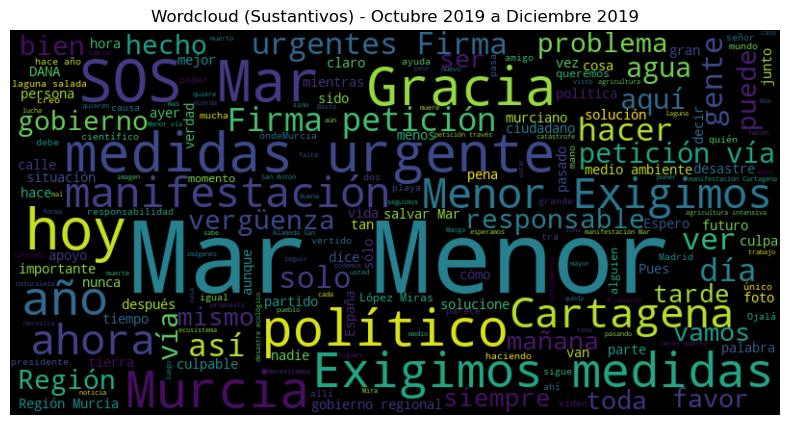

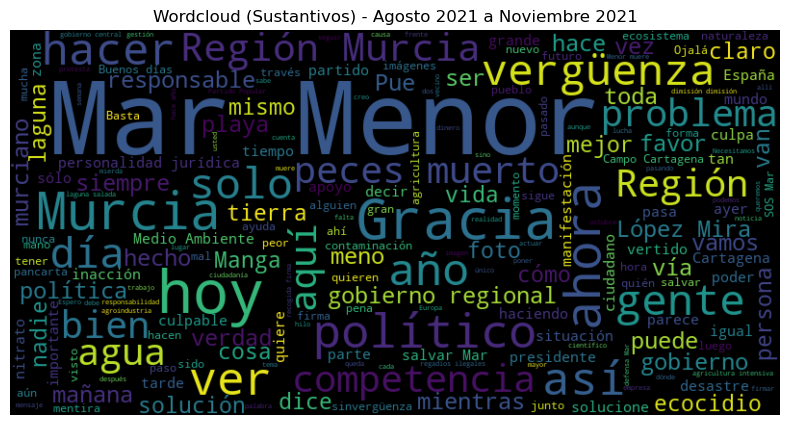

In [128]:
def extract_nouns(text):
    stop_words = set(stopwords.words('spanish'))
    words = word_tokenize(text)
    nouns = [word for word in words if word not in stop_words and word.isalnum() and word[0].isalpha() and len(word) > 2]
    return " ".join(nouns)

def generate_noun_wordcloud(text, title):
    text_with_nouns = extract_nouns(text)
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_with_nouns)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

period1_data = df[(df['Datetime'] >= '2019-10-01') & (df['Datetime'] <= '2019-12-31')]
period2_data = df[(df['Datetime'] >= '2021-08-01') & (df['Datetime'] <= '2021-11-30')]

text_period1 = ' '.join(period1_data['Text_cleaned'])
text_period2 = ' '.join(period2_data['Text_cleaned'])

generate_noun_wordcloud(text_period1, 'Wordcloud (Sustantivos) - Octubre 2019 a Diciembre 2019')
generate_noun_wordcloud(text_period2, 'Wordcloud (Sustantivos) - Agosto 2021 a Noviembre 2021')



2. aplica la técnica conocida como topic modeling al contenido de los tuits. La aplicación de esta técnica debería ayudarte a ser capaz de identificar los temas en torno a los cuales gira la conversación ciudadana en Twitter y los términos los mismos. Valora el uso de la librería pyLDavis para la visualización de datos.

In [135]:
stop_words = set(stopwords.words('spanish'))
tokenizer = ToktokTokenizer()
df["topic_modeling"] = df["Text_cleaned"].apply(tokenizer.tokenize)
df["topic_modeling"] = df["topic_modeling"].apply(lambda x: [word for word in x if word not in stop_words])

In [136]:
df["topic_modeling"]

0        [Agricultura, construcciones, masivas, ningún, respeto, sido, dos, causas, Mar, Menor, muriendo, muerto, óxigeno, agua]
1                             [Instituto, Oceanográfico, alerta, riesgo, nueva, anoxia, Mar, Menor, lluvias, nutrientes, través]
2                                                                                                                             []
3                                                                                                                             []
4                                             [alerta, riesgo, nuevo, episodio, anoxia, eutrofización, esperáis, tomar, medidas]
                                                                  ...                                                           
65573                                    [Seguid, destruyendo, Mar, Menor, luego, quejaros, turismo, vuelve, xq, comen, medusas]
65574                                                          [ANSE, advierte, Valcárcel, pagará

In [137]:
diccionario = Dictionary(df["topic_modeling"])

In [138]:
len(diccionario)


51863

In [140]:
corpus = [diccionario.doc2bow(token) for token in df.topic_modeling]
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=20, random_state=42, 
               chunksize=200, passes=10, alpha='auto')


In [154]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(0, '0.255*"30" + 0.059*"mejor" + 0.040*"nivel" + 0.036*"seguir" + 0.031*"Necesitamos"')
(1, '0.101*"pena" + 0.090*"salvar" + 0.088*"muerte" + 0.087*"responsables" + 0.064*"da"')
(2, '0.102*"agua" + 0.095*"problema" + 0.090*"solo" + 0.085*"sido" + 0.081*"soluciones"')
(3, '0.242*"Murcia" + 0.156*"día" + 0.121*"Región" + 0.116*"Si" + 0.055*"dar"')
(4, '0.145*"políticos" + 0.127*"peces" + 0.081*"va" + 0.054*"muertos" + 0.053*"gente"')
(5, '0.131*"Ahora" + 0.092*"ciudadanos" + 0.038*"espacio" + 0.028*"municipios" + 0.027*"lucha"')
(6, '0.090*"vamos" + 0.081*"tierra" + 0.069*"muchas" + 0.069*"naturaleza" + 0.047*"necesitamos"')
(7, '0.181*"medidas" + 0.093*"vergüenza" + 0.069*"mayor" + 0.053*"parte" + 0.039*"Miras"')
(8, '0.120*"favor" + 0.119*"puede" + 0.098*"vez" + 0.073*"tarde" + 0.058*"región"')
(9, '0.165*"hacer" + 0.093*"así" + 0.079*"agricultura" + 0.046*"hacen" + 0.041*"través"')
(10, '0.139*"ser" + 0.089*"Hoy" + 0.087*"culpa" + 0.051*"Europa" + 0.049*"MAR"')
(11, '0.239*"mar" + 0.

Tópico 0: Podría estar relacionado con el número "30", quizás mencionando algo sobre seguir algo durante cierto período de tiempo.

Tópico 1: Parece estar relacionado con palabras como "pena", "salvar", "muerte", y "responsables". Podría estar abordando problemas medioambientales graves y la necesidad de actuar.

Tópico 2: Contiene palabras relacionadas con el agua, problemas y soluciones. Puede estar relacionado con la discusión de problemas medioambientales relacionados con el agua.

Tópico 3: Menciona lugares como "Murcia", "Región" y "día". Podría estar relacionado con discusiones sobre eventos específicos en la región.

Tópico 11: Enfocado en el "mar menor", "vida", "mundo". Puede estar relacionado con la vida marina y la preocupación por el estado del Mar Menor.

Tópico 17: Destaca "Mar" y "Menor". Probablemente esté dedicado exclusivamente al Mar Menor y sus problemas específicos.

Tópico 18: Contiene palabras como "Gobierno" y "situación". Puede estar abordando la situación política y gubernamental en relación con el medio ambiente.

In [156]:
import pyLDAvis
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario)
pyLDAvis.display(lda_display)

Comprobamos si el modelo funciona correctamente

In [170]:
import random
tweet_index = random.randint(0,len(df))
tweet = df.iloc[tweet_index]
print(tweet.Text_cleaned)
print(tweet.topic_modeling)

Vaya gracia hacer cartagenero usar autovía buscar veranear cantidad purines Grupo Fuertes dejado veraneo encima pagar peaje
['Vaya', 'gracia', 'hacer', 'cartagenero', 'usar', 'autovía', 'buscar', 'veranear', 'cantidad', 'purines', 'Grupo', 'Fuertes', 'dejado', 'veraneo', 'encima', 'pagar', 'peaje']


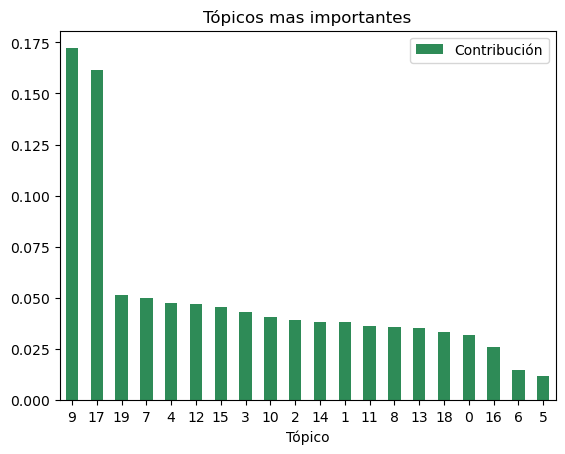

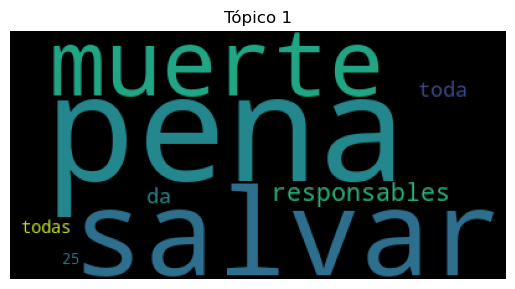

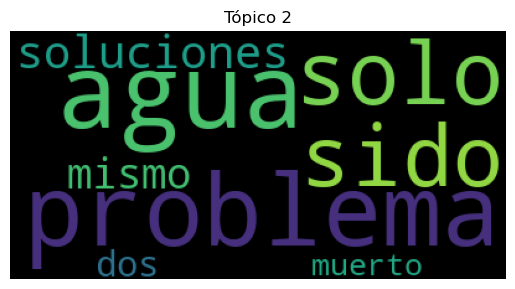

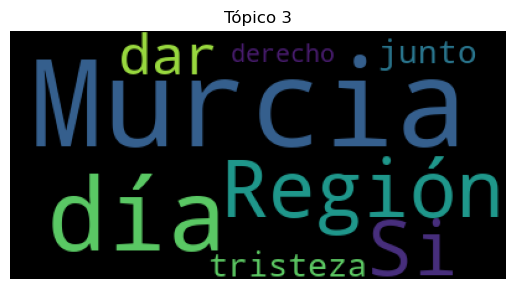

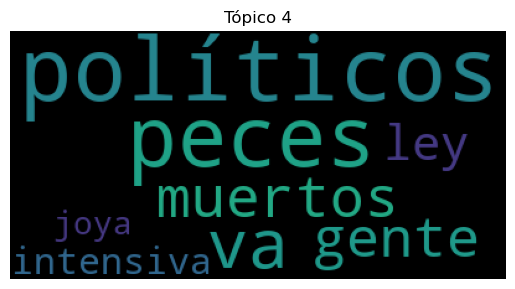

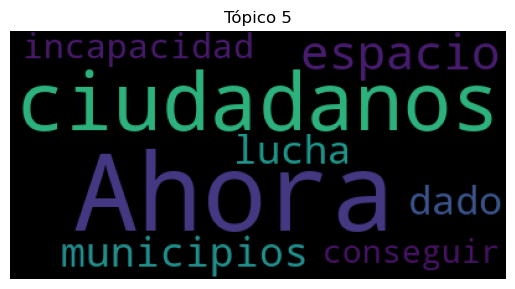

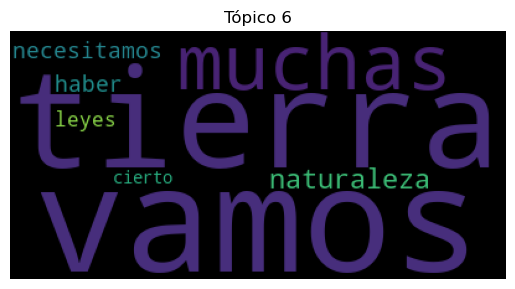

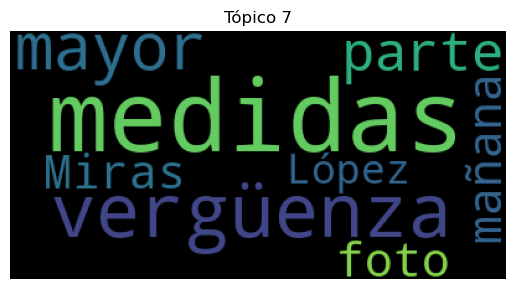

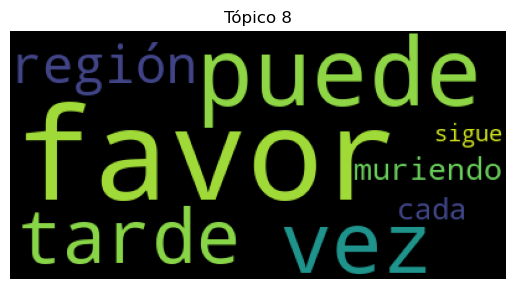

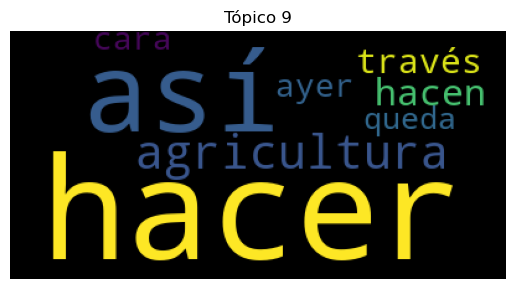

In [197]:
bow_tweet = corpus[tweet_index]
distribution_tweet = lda[bow_tweet]

distribution_topics = pd.DataFrame({'Tópico': [topico[0] for topico in lda[bow_tweet]], 'Contribución': [
                                    topico[1] for topico in lda[bow_tweet]]})
distribution_topics.sort_values('Contribución', ascending=False, inplace=True)
distribution_topics.plot.bar(y='Contribución', x='Tópico',
                              rot=0, color="#2E8B57", title='Tópicos mas importantes')

for i in range(1, 10):
    plt.figure()
    plt.imshow(WordCloud(background_color='black')
               .fit_words(dict(lda.show_topic(i, 8))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

3. aplica en segundo momento la técnica del K-Means para evaluar si se obtienen unos resultados parejos a lo del topic modeling, o bien se apartan de los mismos.

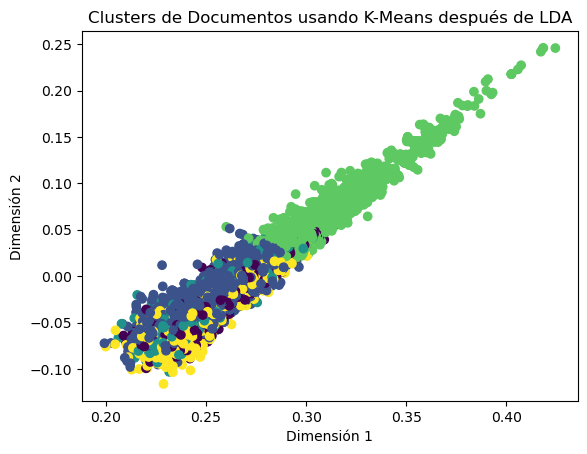

In [200]:
lda_representation = lda[corpus]

num_topics = lda.num_topics
lda_matrix = gensim.matutils.corpus2csc(lda_representation, num_terms=num_topics).T

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(lda_matrix)

tsvd = TruncatedSVD(n_components=2)
lda_matrix_2d = tsvd.fit_transform(lda_matrix)

plt.scatter(lda_matrix_2d[:, 0], lda_matrix_2d[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Clusters de Documentos usando K-Means después de LDA')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

## Conlusiones

¿qué podemos aprender de lo que ha sucedido en torno a la crisis del Mar Menor estos últimos años partiendo de la actividad existente en la redes sociales?

Podemos darnos cuenta del descontento general de la sociedad con como ha gestionado el gobierno la situacion con el Mar Menor, y asi lo han plasmado algunos ciudadanos a traves de las redes sociales en este caso X.